# Inverse Ising problem

This notebook gives examples of how to use the various solvers included in CONIII for solving the inverse Ising problem. In this problem, the goal is to match the average of each spin (the magnetization) $\{\langle\sigma_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle\sigma_{\rm i}\sigma_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$.

The Ising model is given by  
$p(\{\sigma_{\rm i}\}) = \left.e^{-E(\{\sigma_{\rm i}\})}\right/Z$  
$\displaystyle E(\{\sigma_{\rm i}\}) = -\sum_{\rm ij}J_{\rm ij}\sigma_{\rm i}\sigma_{\rm j} -\sum_{\rm i}^Nh_{\rm i}$  
$Z = \displaystyle \sum_{\{\sigma_{\rm i}\}} e^{-E(\{\sigma_{\rm i}\})}$

In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
import ising_eqn_5_sym
import importlib
from misc.plot import colorcycle

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()


def generate_random_systems(n,n_iters,rng=np.random.RandomState(0),n_sample=20):
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
    
    # Generate example data set.
    h = np.random.normal(scale=.1,size=(n_iters,n))  # random fields
    J = np.random.normal(scale=.1,size=(n_iters,n*(n-1)//2))  # couplings
    sisjTrue = np.zeros((n_iters,n+n*(n-1)//2))
    p = np.zeros((n_iters,2**n))
    sample = np.zeros((n_iters,n_sample,n))
    for i in xrange(n_iters):
        hJ = np.concatenate(( h[i],J[i] ))
        p[i] = ising_eqn.p(hJ)  # probability distribution of all states p(s)
        sisjTrue[i] = ising_eqn.calc_observables(hJ)  # exact magnetizations and pairwise correlations
        sample[i,:,:] = allstates[np.random.choice(range(2**n),size=n_sample)]
    return h,J,p,sisjTrue,sample

def runtime_exact(n,sisjTrue):
    # Exact.
    allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
    def calc_observables_multipliers(J):
        """
        Calculate observables from probability distribution given Langrangian multipliers.
        """
        E = calc_e(allstates,J)
        return pair_corr( allstates, np.exp(-E-logsumexp(E)),concat=True )

    # Generate example data set.
    solver = Exact(n,
                   calc_observables_multipliers=calc_observables_multipliers,
                   calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={})
    end = datetime.now()

    error = np.linalg.norm( calc_observables_multipliers(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_mpf(n,sample):
    solver = MPF(n,calc_observables=calc_observables,adj=adj)
    start = datetime.now()
    estMultipliers,soln = solver.solve(sample)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_pseudo(n,sample):
    """
    Pseudolikelihood.
    """
    get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)
    solver = Pseudo(n,calc_observables=calc_observables,
                    calc_observables_r=calc_observables_r,
                    get_multipliers_r=get_multipliers_r)
    start = datetime.now()
    estMultipliers,_ = solver.solve(sample,np.zeros(n+n*(n-1)//2))
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

def runtime_cluster(n,sample,threshold=.3):
    # Adaptive cluster expansion.
    solver = ClusterExpansion(n,calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers = solver.solve(sample,threshold)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime


# Define function for changing learning parameters as we converge.
def learn_settings(i):
    """
    Take in the iteration counter and set the maximum change allowed in any given parameter (maxdlamda)
    and the multiplicative factor eta, where d(parameter) = (error in observable) * eta.
    
    Additional option is to also return the sample size for that step by returning a tuple. Larger 
    sample sizes are necessary for higher accuracy.
    """
    if i<10:
        return {'maxdlamda':1,'eta':1}
    elif i<20:
        return {'maxdlamda':.1,'eta':.1}
    else:
        return {'maxdlamda':.05,'eta':.05}

def runtime_mch(n,sisjTrue):
    # MCH.
    # Import exact equations for Ising model with n spins.
    solver = MCH(n,calc_observables=calc_observables,
                 sample_size=100,
                 sample_method='metropolis',
                 mch_approximation=mchApproximation)
    start = datetime.now()
    estMultipliers = solver.solve(sisjTrue,maxiter=40,custom_convergence_f=learn_settings)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

# Regularized MF.
def runtime_mf(n,sample):
    solver = RegularizedMeanField(n,calc_observables=calc_observables)
    start = datetime.now()
    estMultipliers = solver.solve(sample,numSamples=100)
    end = datetime.now()
    
    # Error and runtime.
    ising_eqn = importlib.import_module('ising_eqn_%d_sym'%n)
    error = np.linalg.norm( ising_eqn.calc_observables(estMultipliers)-sisjTrue )
    runtime = (end-start).total_seconds()
    return error,runtime

# Runtime as a function of n.

In [59]:
# Generate random systems to test across methods.
nrange = range(6,16,2)

# Errors and runtimes in order of exact,MPF,pseudo,cluster,MCH,mean field.
error = [np.zeros((len(nrange),10)) for i in xrange(6)]
runtime = [np.zeros((len(nrange),10)) for i in xrange(6)]
for ncount,n in enumerate(nrange):
    hs,Js,ps,sisjTrues,samples = generate_random_systems(n,10)

    for i,(h,J,p,sisjTrue,sample) in enumerate(zip(hs,Js,ps,sisjTrues,samples)):
        error[0][ncount,i],runtime[0][ncount,i] = runtime_exact(n,sisjTrue)
        error[1][ncount,i],runtime[1][ncount,i] = runtime_mpf(n,sample)
        error[2][ncount,i],runtime[2][ncount,i] = runtime_pseudo(n,sample)
        error[3][ncount,i],runtime[3][ncount,i] = runtime_cluster(n,sample)
        error[4][ncount,i],runtime[4][ncount,i] = runtime_mch(n,sisjTrue)
        error[5][ncount,i],runtime[5][ncount,i] = runtime_mf(n,sample)

    pickle.dump({'runtime':runtime,'error':error},open('temp.p','wb'),-1)

In [88]:
load_pickle('temp.p',1)

Thu Aug 31 13:11:31 EDT 2017



['runtime', 'error']

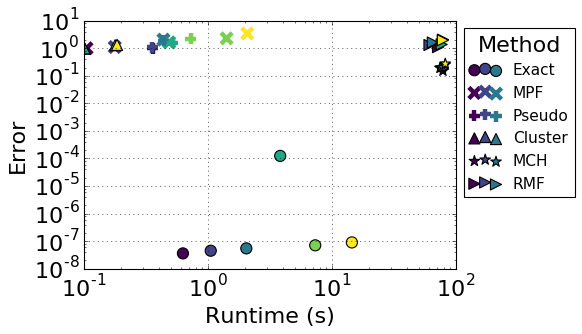

In [89]:
fig,ax = plt.subplots()
markers = 'ox+^*>'
cc = [c for c in colorcycle(len(nrange))]

for m,run,err in zip(markers,runtime,error):
    if m in 'x+':
        lws = 4
    else:
        lws = None
    ax.scatter(run.mean(1),err.mean(1),s=100,c=cc,marker=m,linewidths=lws)
ax.set(xlabel='Runtime (s)',ylabel='Error',xscale='log',yscale='log',ylim=[1e-8,10])
ax.legend(('Exact','MPF','Pseudo','Cluster','MCH','RMF'),title='Method',fontsize='x-small',
          bbox_to_anchor=[1.34,1])
ax.grid()

In [87]:
fig.savefig('/Users/eddie/Downloads/runtime.pdf',bbox_inches='tight')

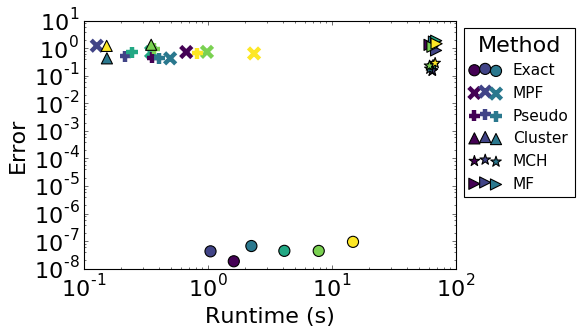

In [58]:
fig,ax = plt.subplots()
markers = 'ox+^*>'
cc = [c for c in colorcycle(runtime.shape[1])]

for m,rowr,rowe in zip(markers,runtime,error):
    if m in 'x+':
        lws = 4
    else:
        lws = None
    ax.scatter(rowr,rowe,s=100,c=cc,marker=m,linewidths=lws)
ax.set(xlabel='Runtime (s)',ylabel='Error',xscale='log',yscale='log',ylim=[1e-8,10])
ax.legend(('Exact','MPF','Pseudo','Cluster','MCH','RMF'),title='Method',fontsize='x-small',
          bbox_to_anchor=[1.34,1])